### add column 

In [103]:
def add_cols(jpath, fpath, cols):
    jpath = '../data/pd_gy/all.json'
    fpath = 'filter0.csv'

    add_cols = ['age','gender']

    import json 
    with open(jpath,'r') as f:
        dj = json.load(f)

    import pandas as pd
    op = pd.read_csv(fpath)

    op = op.rename(columns = {'성별':'gender','나이':'age','KEY':'key'})
    op['key'] = op.key.astype('str')

    l = []
    for i,val in enumerate(dj):
        key  = val['key']
        item = op[op.key==key]
        for col in add_cols:
            col_value = item[col].values[0]
            dj[i][col] = col_value
    return dj

In [124]:
jpath = '../data/pd_gy/all.json'
fpath = 'filter0.csv'

import json 
with open(jpath,'r') as f:
    dj = json.load(f)

import pandas as pd
op = pd.read_csv(fpath)

op = op.rename(columns = {'성별':'gender','나이':'age','KEY':'key'})
op['key'] = op.key.astype('str')

l = []
for i,val in enumerate(dj):
    key  = val['key']
    item = op[op.key==key]
    age = int(item['age'].values[0])
    gender = str(item['gender'].values[0])
    dj[i]['age'], dj[i]['gender'] = age, gender.lower()

In [126]:
import json
with open('../data/pd_gy/all_1.json','w') as f:
    json.dump(dj,f)

### 3 hold out 

In [1]:
jpath = '../data/pd_gy/all_1.json'

import json
with open(jpath, 'r') as f:
    jf = json.load(f)

In [2]:
from utils import num2class

for i,val in enumerate(jf):
    jf[i]['nrs_2'] = num2class(val['nrs'])

In [15]:
import pandas as pd

from sklearn.model_selection import train_test_split

# train:val:test = 3:1:1
nrs2_0 = pd.DataFrame(jf)['nrs_2']
xtr, xte= train_test_split(jf, test_size=0.2, shuffle=True, stratify=nrs2_0, random_state=34)
nrs2_1 = pd.DataFrame(xtr)['nrs_2']
xtr, xval= train_test_split(xtr, test_size=0.25, shuffle=True, stratify=nrs2_1, random_state=34)

In [ ]:
with open('../data/pd_gy/train.json','w') as f:
    json.dump(xtr,f)
with open('../data/pd_gy/val.json','w') as f:
    json.dump(xval,f)
with open('../data/pd_gy/test.json','w') as f:
    json.dump(xte,f)

### Only General Anesthesia 

In [1]:
import json
with open('../data/pd_gy/all_1.json','r') as f:
    jf = json.load(f)

In [6]:
keys = [int(s['key']) for s in jf]

In [2]:
op0p = './data/수술기본_과거력_21상.xlsx'
op1p = './data/수술기본_과거력_21하.xlsx'
op2p = './data/수술기본_과거력_22상.xlsx'

import pandas as pd

op0 = pd.read_excel(op0p, engine='openpyxl',header=1).rename(columns={'Unnamed: 0':'key'})
op1 = pd.read_excel(op1p, engine='openpyxl',header=1).rename(columns={'Unnamed: 0':'key'})
op2 = pd.read_excel(op2p, engine='openpyxl',header=1).rename(columns={'Unnamed: 0':'key'})

In [8]:
op0 = op0[op0.key.isin(keys)]
op1 = op1[op1.key.isin(keys)]
op2 = op2[op2.key.isin(keys)]

In [9]:
op = pd.concat([op0,op1,op2])

In [14]:
op[['마취종류']].value_counts()

마취종류      
General       1109
Spinal         188
MAC             63
General 전환       7
dtype: int64

In [165]:
op[['수술명']].value_counts().to_csv('./data/surgery.csv')

In [166]:
op[['수술 전 진단']].value_counts().to_csv('./data/pre-op-diagnosis.csv')

In [139]:
len(op0[op0.KEY.isin(keys)])+len(op1[op1.KEY.isin(keys)])+len(op2[op2.KEY.isin(keys)])

1766

In [132]:
keys= []
for samp in jf:
    keys.append(samp['key'])

### PPG 

In [16]:
jpath = '../data/pd_gy/all_1.json'
root_dir = '../data/pd_gy/'
import json 
with open(jpath,'r') as f:
    jf = json.load(f)

from utils import num2class
for i,val in enumerate(jf):
    jf[i]['nrs_2'] = num2class(val['nrs'])

sample_rate =3000
min5 = sample_rate*60*5

In [114]:
# ppg mean, std
import os
l = []
stds = []
means = []
from tqdm.notebook import tqdm
for i in tqdm(range(len(jf))):
    idx = i
    recp = jf[idx]['rec_path'][0].replace('\\','/')
    recp = os.path.join(root_dir,recp)
    orp = jf[idx]['or_path'][0].replace('\\','/')
    orp = os.path.join(root_dir, orp)

    import vitaldb

    vf = vitaldb.VitalFile(recp,track_names=['Intellivue/PLETH','Intellivue/NIBP_SYS'])

    ppg = vf.to_numpy('Intellivue/PLETH',1/sample_rate)
    nibp = vf.to_numpy('Intellivue/NIBP_SYS',1/sample_rate)

#     first_idx = 0 
#     for i, value in enumerate(nibp):
#         if pd.isna(value):
#             continue
#         else:
#             first_idx = i
#             break

#     ppg = ppg[first_idx:first_idx+min5]
    
    means.append(np.nanmean(ppg))
    stds.append(np.nanstd(ppg))

  0%|          | 0/1766 [00:00<?, ?it/s]

In [ ]:
# get ppg
import os
idx = 3
# get path
recp = jf[idx]['rec_path'][0].replace('\\','/')
recp = os.path.join(root_dir,recp)
orp = jf[idx]['or_path'][0].replace('\\','/')
orp = os.path.join(root_dir, orp)

import vitaldb

# rec ppg
vf = vitaldb.VitalFile(recp,track_names=['Intellivue/PLETH','Intellivue/NIBP_SYS'])

ppg = vf.to_numpy('Intellivue/PLETH',1/sample_rate)
nibp = vf.to_numpy('Intellivue/NIBP_SYS',1/sample_rate)

first_idx = 0 
for i, value in enumerate(nibp):
    if pd.isna(value):
        continue
    else:
        first_idx = i
        break

ppg = ppg[first_idx:first_idx+min5]

# or ppg
vf = vitaldb.VitalFile(orp,track_names=['Intellivue/PLETH','Intellivue/NIBP_SYS'])

ppg_or = vf.to_numpy('Intellivue/PLETH',1/sample_rate)
nibp_or = vf.to_numpy('Intellivue/NIBP_SYS',1/sample_rate)


first_idx = 0 
for i, value in enumerate(nibp_or):
    if pd.isna(value):
        continue
    else:
        first_idx = i
        break

ppg_or = ppg_or[first_idx:first_idx+min5]

#### band pass

In [ ]:
from scipy import signal
fw = signal.firwin(101,[0.5, 10],fs=sample_rate,pass_zero='bandpass')
bp_ppg = signal.lfilter(fw,[1.0],ppg)

#### moving average

In [80]:
import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

#### z-score 

In [123]:
ppg_norm = (ppg-46.9)/15.5

#### spectrogram 

In [125]:
from torchaudio import transforms as T

In [128]:
n_fft = sample_rate*10 # 10 sec
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    hop_length=n_fft
)

In [140]:
import torch
ppg_t = torch.tensor(ppg_norm).reshape(1,-1)

In [157]:
len(ppg_norm)

7205660

In [156]:
pd.DataFrame(ppg_norm).isna().sum()

0    936867
dtype: int64

In [90]:
ppg_ma = moving_average(ppg.flatten(),30)

In [ ]:
def get_ppg(path, type_):
    if type_ == 'or':
        # nibp+5
    elif type_ == 'rec':
        # 5min
    return signal

In [ ]:
def preprocess(signal):
    # band pass (0.5)
    # 30-tap moving average  
    # z-score    
    # spectogram
    return signal

In [ ]:
# PPG DT
or_ppg = get_ppg(pdorp, type_='or')
or_ppg = preprocess(or_ppg)

rec_ppg = get_ppg(pdorp, type_='rec')
rec_ppg = preprocess(rec_ppg)


In [ ]:
# final goal
import torch
from dataset import PPGDT

trdt  = PPGDT(op_path= '../data/vital2/dd_all_simple_train.csv')
tedt  = PPGDT(op_path= '../data/vital2/dd_all_simple_test.csv')

trdl  = torch.utils.data.DataLoader(trdt, batch_size=4)
tedl  = torch.utils.data.DataLoader(tedt, batch_size=4)

In [87]:
nibpc =['Intellivue/NIBP_SYS','Intellivue/NIBP_DIA','Intellivue/NIBP_MEAN','Intellivue/NIBP_HR']

### PPG + [name, age] 

### etc 

In [73]:
lf=pd.DataFrame(l)

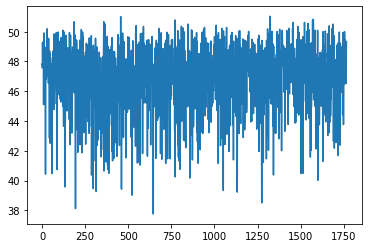

In [118]:
from matplotlib import pyplot as plt
plt.plot(means)

In [120]:
np.mean(means)

46.902824

In [121]:
np.mean(stds)

15.5734005